## Setup Environment

In [30]:
# !pip install langgraph langchain-google-genai langchain-community ddgs langchain-core 

In [31]:
import os
import time
import getpass
from typing import TypedDict, Literal
from IPython.display import Image, display  # Required for Jupyter Visualization

# --- 1. SETUP & IMPORTS ---
from langgraph.types import Command
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_core.messages import HumanMessage

print("✅ Libraries imported successfully.")

✅ Libraries imported successfully.


## Configuration & API Key

In [32]:
# API KEY SETUP
# Ideally set this in your environment variables. 
# For this script to run, ensure you have a valid key.
if "GOOGLE_API_KEY" not in os.environ:
    os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter your Google Gemini API Key: ")

In [33]:
# Initialize LLM and Tools
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", temperature=0.7)
search_tool = DuckDuckGoSearchRun()

## State & Node Definitions

In [34]:
# --- 2. STATE DEFINITION ---
# This dictionary defines the "Memory" schema for our agent.
class AgentState(TypedDict):
    topic: str              # The input topic
    search_data: str        # Web search results
    draft: str              # Current draft text
    critique: str           # Editor's feedback
    revision_count: int     # Safety counter for loops
    final_status: str       # Published status

# --- 3. NODE DEFINITIONS (The Workers) ---

def researcher_node(state: AgentState):
    """Searches the web for context about the topic."""
    topic = state['topic']
    print(f"\n🔎 [Researcher]: Searching web for '{topic}'...")
    try:
        search_result = search_tool.invoke(f"latest trends and news {topic}")
    except Exception as e:
        search_result = "Search failed, using general knowledge."
    
    return {"search_data": search_result, "revision_count": 0}

def writer_node(state: AgentState):
    """Writes a draft. Adapts based on whether it's a first try or a rewrite."""
    iteration = state.get("revision_count", 0) + 1
    print(f"\n✍️ [Writer]: Drafting content (Iteration {iteration})...")
    
    # Context Construction
    if state.get("critique") and state["critique"] != "approved":
        # REWRITE MODE
        prompt = f"""
        You are a LinkedIn content creator. Fix your previous draft based on this feedback:
        FEEDBACK: "{state['critique']}"
        
        PREVIOUS DRAFT: "{state['draft']}"
        
        Write the improved version now.
        """
    else:
        # FIRST DRAFT MODE
        prompt = f"""
        You are a LinkedIn content creator. Write a professional, engaging post about: {state['topic']}.
        
        Use this web context:
        {state['search_data']}
        
        Requirements:
        - Max 200 words.
        - Use appropriate emojis.
        - Professional but viral tone.
        """
    
    response = llm.invoke([HumanMessage(content=prompt)])
    return {"draft": response.content, "revision_count": iteration}

def editor_node(state: AgentState) -> Command[Literal["writer", "human_review"]]:
    """
    The 'Brain' of the operation. 
    It critiques the work and decides the next step using the Command object.
    """
    print(f"\n🧐 [Editor]: Reviewing the draft...")
    
    # 1. Safety Guardrail: Prevent infinite loops
    if state["revision_count"] >= 3:
        print("⚠️ [Editor]: Max revisions reached. Forwarding to human.")
        return Command(
            update={"critique": "max_revisions_reached"},
            goto="human_review"
        )

    # 2. LLM Evaluation
    prompt = f"""
    You are a Senior Editor. Review this LinkedIn post:
    "{state['draft']}"
    
    Criteria:
    1. Is it concise (under 200 words)?
    2. Is it engaging?
    
    If it is good, return EXACTLY: "APPROVE"
    If it needs work, return: "REJECT: [Brief reason]"
    """
    
    response = llm.invoke([HumanMessage(content=prompt)])
    decision = response.content.strip()

    # 3. Dynamic Routing
    if "APPROVE" in decision:
        return Command(
            update={"critique": "approved"},
            goto="human_review"  # Move forward to human
        )
    else:
        reason = decision.replace("REJECT:", "").strip()
        print(f"🔙 [Editor]: Rejected ({reason}). Sending back to Writer.")
        return Command(
            update={"critique": reason},
            goto="writer"       # Loop back to writer
        )

def human_review_node(state: AgentState):
    """
    A passive node. It simply displays the draft before the graph pauses.
    The pause happens because of 'interrupt_before' in the compile step.
    """
    print(f"\n🛑 [System]: Draft approved by AI. Pausing for Human Review.")
    print(f"{'-'*40}")
    print(f"TOPIC: {state['topic']}")
    print(f"DRAFT:\n{state['draft']}")
    print(f"{'-'*40}")

def publisher_node(state: AgentState):
    """Simulates publishing via API."""
    print(f"\n🚀 [API]: Publishing post to LinkedIn...")
    # Here you would add real LinkedIn API calls
    time.sleep(1)
    print(f"✅ [API]: Published successfully!")
    return {"final_status": "published"}

## Graph Constructions & Visualizations

Current Agent Graph:


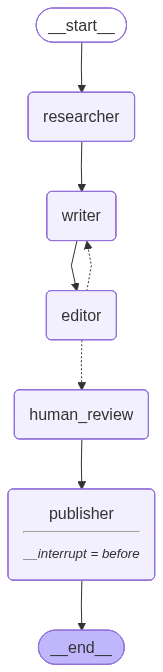

In [35]:
# --- 4. BUILD THE GRAPH ---

workflow = StateGraph(AgentState)

# Add Nodes
workflow.add_node("researcher", researcher_node)
workflow.add_node("writer", writer_node)
workflow.add_node("editor", editor_node)
workflow.add_node("human_review", human_review_node)
workflow.add_node("publisher", publisher_node)

# Add Edges (Linear Flow)
# Note: editor -> writer/human logic is handled inside editor_node via Command
workflow.add_edge(START, "researcher")
workflow.add_edge("researcher", "writer")
workflow.add_edge("writer", "editor")

workflow.add_edge("human_review", "publisher")
workflow.add_edge("publisher", END)

# Compile with Memory
# We use MemorySaver to simulate persistence in RAM.
memory = MemorySaver()

# interrupt_before=["publisher"] ensures the agent stops AFTER human_review node runs,
# giving us a chance to approve or reject.
app = workflow.compile(checkpointer=memory, interrupt_before=["publisher"])

# --- VISUALIZATION FOR JUPYTER ---
print("Current Agent Graph:")
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    print("Graphviz not found. Install it to see the diagram, but code will run fine.")

## Interactive Execution

In [36]:
# --- 5. DEMONSTRATION OF SKILLS (INTERACTIVE) ---


print("\n\n" + "="*50)
print("🎬 STARTING MULTI-THREAD MEMORY DEMO")
print("="*50)
print("We will start two separate tasks (Thread A and Thread B).")
print("The agent will keep their states completely separate.")

# --- STEP 1: Kick off Task A (Thread A) ---
thread_a_config = {"configurable": {"thread_id": "thread_A"}}
print(f"\n🔹 [Thread A]: Starting task 'Generative AI'")
app.invoke({"topic": "Generative AI Agents"}, config=thread_a_config)

print("\n❄️ [System]: Thread A is now FROZEN at 'Human Review'.")



🎬 STARTING MULTI-THREAD MEMORY DEMO
We will start two separate tasks (Thread A and Thread B).
The agent will keep their states completely separate.

🔹 [Thread A]: Starting task 'Generative AI'

🔎 [Researcher]: Searching web for 'Generative AI Agents'...

✍️ [Writer]: Drafting content (Iteration 1)...

🧐 [Editor]: Reviewing the draft...
🔙 [Editor]: Rejected (A bit too promotional, especially with the double mention of specific products. Could be more focused on the impact of AI agents.). Sending back to Writer.

✍️ [Writer]: Drafting content (Iteration 2)...

🧐 [Editor]: Reviewing the draft...

🛑 [System]: Draft approved by AI. Pausing for Human Review.
----------------------------------------
TOPIC: Generative AI Agents
DRAFT:
Okay, here's a revised LinkedIn post, focusing more on the impact of AI agents and less on specific product promotion:

**Revised Draft:**

"🤯 The Rise of the AI Agent: A New Era of Automation and Innovation! 🚀

This week, the buzz is all about AI agents – auto

In [37]:
# --- STEP 2: Kick off Task B (Thread B) ---
# Notice we switch context completely. Thread A's data is safe in memory.
thread_b_config = {"configurable": {"thread_id": "thread_B"}}
print(f"\n🔸 [Thread B]: Starting task 'Remote Work'")
app.invoke({"topic": "Remote Work Life Balance"}, config=thread_b_config)

print("\n❄️ [System]: Thread B is now FROZEN at 'Human Review'.")

# --- STEP 3: Resume Thread A (Demonstrating Memory Retrieval) ---
print("\n" + "="*50)
print("🔄 CONTEXT SWITCH: Switching back to Thread A")
print("="*50)


🔸 [Thread B]: Starting task 'Remote Work'

🔎 [Researcher]: Searching web for 'Remote Work Life Balance'...

✍️ [Writer]: Drafting content (Iteration 1)...

🧐 [Editor]: Reviewing the draft...

🛑 [System]: Draft approved by AI. Pausing for Human Review.
----------------------------------------
TOPIC: Remote Work Life Balance
DRAFT:
## Remote Work Life Balance: Myth or Reality? 🤔

Navigating the remote work life can feel like walking a tightrope! 🤸‍♀️ We've all been there: blurring lines between work and personal time, struggling to disconnect, and feeling perpetually "on."

But is true work-life balance achievable in the remote world? I think so, but it requires conscious effort! 🔑

Here are a few tips that have helped me:

*   **Set clear boundaries:** Define your working hours and stick to them. ⏰
*   **Create a dedicated workspace:** This helps mentally separate work from home. 🏠➡️🏢
*   **Prioritize self-care:** Schedule breaks, exercise, and time for hobbies. 🧘‍♀️
*   **Communicate 

In [38]:
# We query the state of Thread A to show it remembers the draft
current_state_a = app.get_state(thread_a_config)
print(f"Retrieving Thread A Draft from Memory:\n -> {current_state_a.values['draft']}...")

# --- INTERACTIVE INPUT ---
user_input = input("👤 [User]: Do you approve Thread A? (type 'yes' or 'no'): ")

if user_input.lower() == "yes":
    # Passing None resumes execution from the breakpoint
    app.invoke(None, config=thread_a_config)
else:
    print("❌ Thread A Cancelled.")

Retrieving Thread A Draft from Memory:
 -> Okay, here's a revised LinkedIn post, focusing more on the impact of AI agents and less on specific product promotion:

**Revised Draft:**

"🤯 The Rise of the AI Agent: A New Era of Automation and Innovation! 🚀

This week, the buzz is all about AI agents – autonomous systems capable of handling complex tasks and transforming how we work. We're moving beyond simple automation to a world where AI can proactively solve problems and drive efficiency in unprecedented ways.

Imagine AI agents managing customer service inquiries, optimizing supply chains, or even conducting initial research for complex projects. The potential impact on productivity and innovation is enormous.

The advancements in large context windows and processing power are key to this evolution, allowing AI agents to understand and respond to nuanced situations with greater accuracy. This opens up exciting possibilities for businesses across all sectors.

The democratization of AI

In [39]:
# --- STEP 4: Resume Thread B ---
print("\n" + "="*50)
print("🔄 CONTEXT SWITCH: Switching back to Thread B")
print("="*50)

current_state_b = app.get_state(thread_b_config)
print(f"Retrieving Thread B Draft from Memory:\n -> {current_state_b.values['draft']}...")

# --- INTERACTIVE INPUT ---
user_input_b = input("👤 [User]: Do you approve Thread B? (type 'yes' or 'no'): ")

if user_input_b.lower() == "yes":
    app.invoke(None, config=thread_b_config)
else:
    print("❌ Thread B Cancelled.")

print("\n✅ DEMO COMPLETE: Both threads handled.")


🔄 CONTEXT SWITCH: Switching back to Thread B
Retrieving Thread B Draft from Memory:
 -> ## Remote Work Life Balance: Myth or Reality? 🤔

Navigating the remote work life can feel like walking a tightrope! 🤸‍♀️ We've all been there: blurring lines between work and personal time, struggling to disconnect, and feeling perpetually "on."

But is true work-life balance achievable in the remote world? I think so, but it requires conscious effort! 🔑

Here are a few tips that have helped me:

*   **Set clear boundaries:** Define your working hours and stick to them. ⏰
*   **Create a dedicated workspace:** This helps mentally separate work from home. 🏠➡️🏢
*   **Prioritize self-care:** Schedule breaks, exercise, and time for hobbies. 🧘‍♀️
*   **Communicate your needs:** Let your team know when you're unavailable. 🗣️

Remote work offers incredible flexibility, but it's up to us to harness it for a fulfilling, balanced life. What are your go-to strategies for achieving work-life harmony? Share in t